In [1]:
import numpy as np
import pandas as pd
import matplotlib

CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.size": 16,

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 1.5,
    "lines.linewidth": 1.5,
    # "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none",
    "savefig.dpi": 300,

    # Higher DPI for sharper inline images
    "figure.dpi": 96
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

In [25]:
faked_omega = 55.527527527527525,
fA, fB, fC, fD = [-231.9995804191791, 65.16789057491285, 623.2713748569529, 418209.514533977]
faked_depth = 0.00012063687154861835

first_transit_time = 57531.91792371155 - pivot
transit_duration = 166.484 / 24 / 3600
transit_period = 2.025026511149096 / 24
transit_count = 6

In [27]:
df = pd.read_csv("data.dat", delimiter="\t", names=("time", "flux", "err_flux"))

pivot = df["time"].median()
df["ptime"] = df["time"] - pivot
df["ftime"] = df["ptime"] - transit_period * ((df["ptime"] - first_transit_time - transit_period/2) // transit_period)

def find_pt(pt):
    return np.searchsorted(df["ptime"], pt)

def find_window(pt, width):
    return (
        np.clip(find_pt(pt-width/2), 0, len(df)),
        np.clip(find_pt(pt+width/2), 0, len(df))
    )

transit_idx = []
for tn in range(6):
    w = find_window(tn*transit_period+first_transit_time, transit_duration)
    if w[1] - w[0] > 3:
        transit_idx.append(w)

transit_mask = np.zeros(len(df), dtype=bool)
for ti, tf in transit_idx:
    transit_mask[ti:tf] = True

In [28]:
df["flux"] = fA * np.sin(faked_omega * df["ptime"]) \
    + fB * np.cos(faked_omega * df["ptime"]) \
    + fC * df["ptime"] + fD \
    + np.random.normal(0.0, df["err_flux"])

df["flux"][transit_mask] *= 1-faked_depth

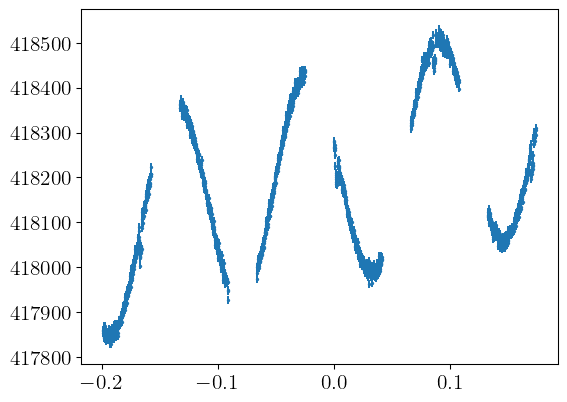

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(df["ptime"], df["flux"], fmt="o", yerr=df["err_flux"])
plt.show()

In [33]:
obs_start = (0, *(1 + np.where(np.diff(df["ptime"]) > 0.001)[0]), len(df))
obs_windows = list(zip(obs_start[:-1], obs_start[1:]))
obs_windows

[(0, 268), (268, 536), (536, 802), (802, 1065), (1065, 1335), (1335, 1605)]

In [34]:
outlier_mask = np.zeros(len(df), dtype=bool)

# iterate over each observation section
for iS, iF in obs_windows:
    # Use a five point bandwidth
    for i in range(iS+2, iF-2):
        med = df["flux"][i-2:i+3].median()
        if abs(df["flux"][i] - med) / df["err_flux"][i] > 3:
            outlier_mask[i] = True

# Manually filter out outlier at the end of one window
o = obs_windows[4][1]
outlier_mask[o-2] = True

df_outlier = df[outlier_mask]
df_clean = df[~(outlier_mask | transit_mask)]
df_transit_clean = df[transit_mask & ~outlier_mask]
df_clean_full = df[~outlier_mask]

np.where(outlier_mask)

(array([ 387,  532,  824,  826,  991, 1168, 1333, 1402]),)

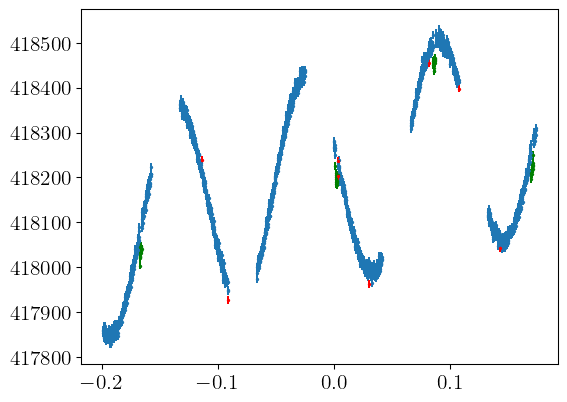

In [35]:
fig, ax = plt.subplots()
ax.errorbar(df_clean["ptime"], df_clean["flux"], fmt="o", yerr=df_clean["err_flux"])
ax.errorbar(df_transit_clean["ptime"], df_transit_clean["flux"], fmt="go", yerr=df_transit_clean["err_flux"])
ax.errorbar(df_outlier["ptime"], df_outlier["flux"], fmt="ro", yerr=df_outlier["err_flux"])
plt.show()

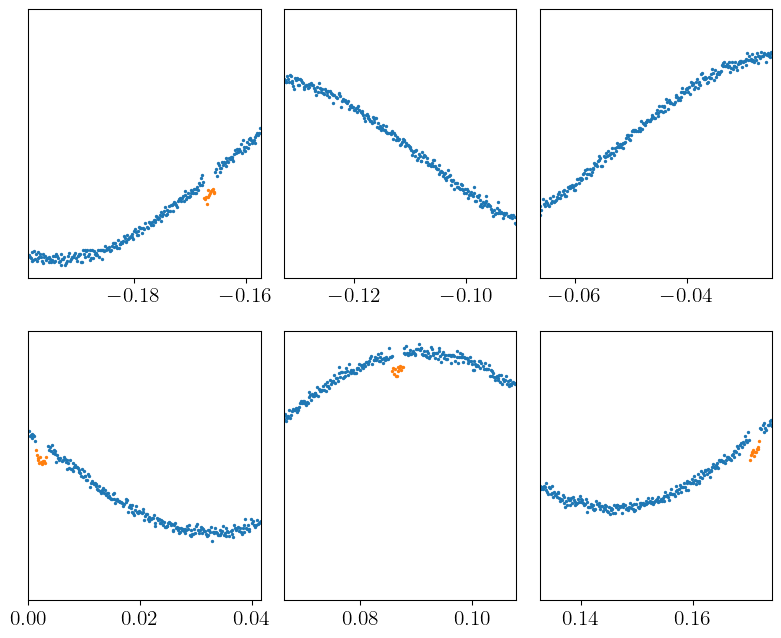

In [36]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(10, 8))
fig.subplots_adjust(wspace=0.1)

for w in range(6):
    ax = axs.ravel()[w]

    ax.scatter(df_clean["ptime"], df_clean["flux"])# fmt="o", yerr=df_clean["err_flux"])
    ax.scatter(df_transit_clean["ptime"], df_transit_clean["flux"])#fmt="go", yerr=df_transit_clean["err_flux"])

    ax.set_xlim(df["ptime"][obs_windows[w][0]], df["ptime"][obs_windows[w][1]-1])
    
    ax.set_yticks([])

In [10]:
# From LEC3, a Lomb-Scargle periodogram is just a bunch of regressions with sines and cosines
# in the design matrix. Let's bake in the linear trend to not have to worry about it separately.

omegas = np.linspace(40, 70, 1000)

t = np.asarray(df_clean["ptime"])
y = np.asarray(df_clean["flux"])
dy = np.asarray(df_clean["err_flux"])

yw = y / dy
chi2 = np.full_like(omegas, np.nan)

def fit(omega):
    # Set up the design matrix X with a sin, cos, linear, and constant term
    Xw = np.column_stack([
        np.sin(omega * t),
        np.cos(omega * t),
        t,
        np.ones_like(t)
    ]) / dy[:, None]

    beta = np.linalg.solve(Xw.T @ Xw, Xw.T @ yw)
    chi2 = np.sum((yw - Xw @ beta)**2)

    return beta, chi2

def model(t, omega, beta):
    return np.column_stack([
        np.sin(omega * t),
        np.cos(omega * t),
        t,
        np.ones_like(t)
    ]) @ beta

for i, omega in enumerate(omegas):
    chi2[i] = fit(omega)[1]

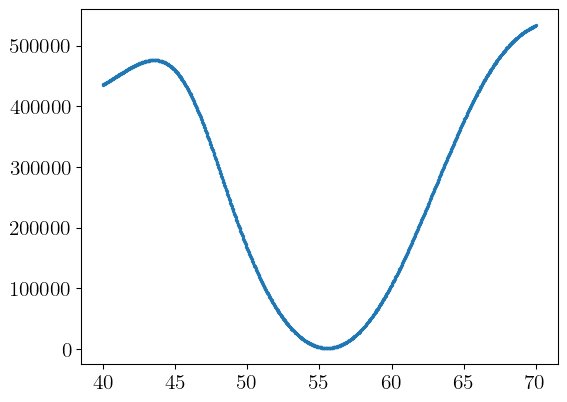

In [11]:
plt.scatter(omegas, chi2)

In [12]:
# Repeat on a smaller window with better resolution
omegas = np.linspace(55, 56, 1000)
chi2 = np.full_like(omegas, np.nan)

for i, omega in enumerate(omegas):
    chi2[i] = fit(omega)[1]

In [13]:
omega_best = omegas[np.argmin(chi2)]
beta, _ = fit(omega_best)

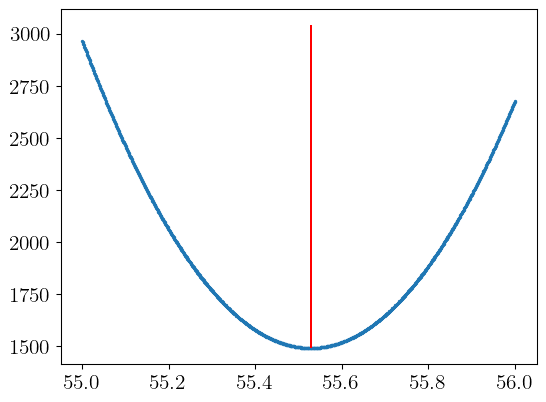

In [14]:
fig, ax = plt.subplots()
ax.scatter(omegas, chi2)
ax.vlines(omega_best, np.min(chi2), ax.get_ylim()[1], "r")
plt.show()

In [15]:
beta

array([-2.31999580e+02,  6.51678906e+01,  6.23271375e+02,  4.18209515e+05])

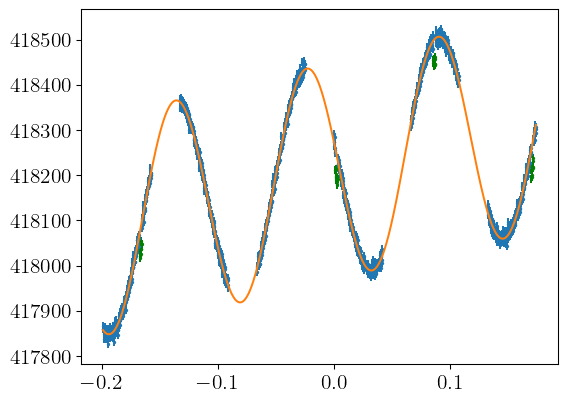

In [16]:
fig, ax = plt.subplots()
ax.errorbar(df_clean["ptime"], df_clean["flux"], fmt="o", yerr=df_clean["err_flux"])
ax.errorbar(df_transit_clean["ptime"], df_transit_clean["flux"], fmt="go", yerr=df_transit_clean["err_flux"])
t_plot = np.linspace(df_clean["ptime"].min(), df_clean["ptime"].max(), 10000)
ax.plot(t_plot, model(t_plot, omega_best, beta), zorder=99)
plt.show()

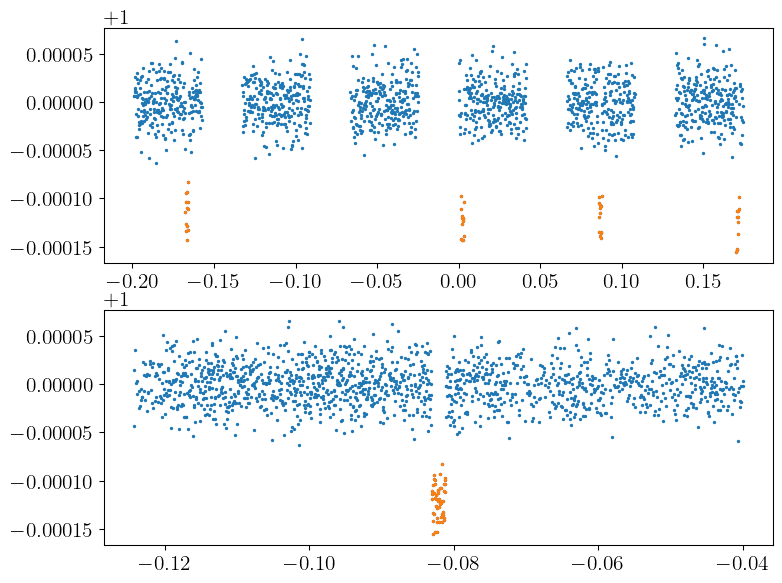

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 7), sharey=True)

ax1.plot(df_clean_full["ptime"], df_clean_full["flux"]/model(df_clean_full["ptime"], omega_best, beta), "o")
ax2.plot(df_clean_full["ftime"], df_clean_full["flux"]/model(df_clean_full["ptime"], omega_best, beta), "o")

ax1.plot(df_transit_clean["ptime"], df_transit_clean["flux"]/model(df_transit_clean["ptime"], omega_best, beta), "o")
ax2.plot(df_transit_clean["ftime"], df_transit_clean["flux"]/model(df_transit_clean["ptime"], omega_best, beta), "o")

plt.show()

In [47]:
print("Transit depth estimate:", 1-np.mean(df_transit_clean["flux"]/model(df_transit_clean["ptime"], omega_best, beta)))

Transit depth estimate: 0.00012063687154861835


In [38]:
try:
    import numba
    import functools

    nogiljit = functools.partial(numba.jit, nogil=True, nopython=True)
    prange = numba.prange
except ImportError:
    import warnings

    warnings.warn(
        "Numba not installed. Code will run many times slower. It is "
        "recommmended you install it using `pip install numba` or "
        "`conda install numba`."
    )
    nogiljit = lambda x: x
    prange = range

def log_likelihood_chi2_noise(model, x, y, sigma_y, **kwargs):
    """Factory for the generic the chi^2 likelihood function

    Returns a Numba jit'd function taking some input parameters and evaluates
    log(P(theta | D)) the log likelihood of the parameters theta based on the
    observed data (x, y, sigma_y). Output is improper.

    Assumes that the theta vector contains as its last element an extra noise
    (intrinsic) scatter term that should not be passed to the model. The
    noise term is added to the _squared uncertainty_ of the data (sigma_y^2).
 
    Args:
        model (factory_function): A factory function that takes in the array x
        and returns a function that models y at each x based on the parameters
        theta.
        x (array_like): Observation data x.
        y (array_like): Observation data y (is compared with model). Has the
        same dimensions as x.
        sigma_y (array_like): Uncertainty of observations. Has the same
        dimensions as x.
    """

    _model = model(x, y, sigma_y, **kwargs)

    sigma_y2 = sigma_y**2

    @nogiljit
    def _log_likelihood_chi2_noise(theta):
        if theta[-1] < 0.:
            return -np.inf
        SpV = sigma_y2 + theta[-1]
        return -0.5*np.sum(
            np.log(SpV) +  (y - _model(theta[:-1]))**2 / SpV
        )

    return _log_likelihood_chi2_noise

def log_likelihood_chi2(model, x, y, sigma_y):
    """Factory for the generic chi^2 likelihood function

    Returns a Numba jit'd function taking some input parameters and evaluates
    log(P(theta | D)) the log likelihood of the parameters theta based on the
    observed data (x, y, sigma_y). Output is improper.

    Args:
        model (factory_function): A factory function that takes in the array x
        and returns a function that models y at each x based on the parameters
        theta.
        x (array_like): Observation data x.
        y (array_like): Observation data y (is compared with model). Has the
        same dimensions as x.
        sigma_y (array_like): Uncertainty of observations. Has the same
        dimensions as x.
    """    

    _model = model(x, y, sigma_y)

    # this factor is constant in the denominator
    two_sigma_y2 = 2*(sigma_y**2)

    @nogiljit
    def _log_likelihood_chi2(theta):
        return -np.sum((y - _model(theta))**2 / two_sigma_y2)

    return _log_likelihood_chi2

def walker(log_probability_fn):
    """Returns a function that performs a MCMC walk from a specified
    (log) probability function, initial theta, and step_size.

    The function expects you to "bring your own array" to store the
    parameter and likelihood samples, allowing to treat each row of
    a higher dimensional array as a separate chain.

    The initial state should be specified as the beginning element in
    the theta array before passing it into the walk function, e.g.,
        theta[0, :] = initial_state

    The theta array should have shape (steps, number of parameters)
    and the optional log_probability save should have shape (steps,)

    To avoid serious memory fragmentation issues, you should ensure
    the supplied arrays are "C-contiguous". This should be the case
    by default with numpy if the "steps" dimension is the second to
    last index and the "parameter" dimension is the last index and
    no transposition or reordering is applied.

        See numpy documentation for more information on memory contiguity:
        https://numpy.org/doc/stable/dev/internals.html#

    Currently only supports Gaussian proposals. step_size is interpreted
    as the standard deviation of the sampled normal distribution for each
    parameter.

    This factory function is separate from walk_all to take advantage
    of numba compilation caching between separate runs.

    Args:
        log_probability_fn (function):
            a numba jit function accepting a single parameter theta and
            returning the log probability.        
    """    
    @nogiljit
    def _walk(state, steps, step_scale, last_log_probability, log_probability_save=None):
        for i in range(1, steps):
            # Generate a new proposal using a Gaussian for each parameter
            for j, s in enumerate(step_scale):
                state[i, j] = state[i-1, j] + np.random.normal(0, s)

            log_probability_proposal = log_probability_fn(state[i])
            
            # Metropolis method. This is the calculation to _reject_
            # the proposal, since we've already written the proposal to the
            # array
            #
            # If the new probability is greater than the old one, accept,
            # otherwise accept with P(accept) = P(theta_proposal)/P(theta)
            lp_diff = log_probability_proposal - last_log_probability

            if lp_diff > 0.0 or np.log(np.random.rand()) < lp_diff:
                # Proposal accepted, update last_log_probability
                last_log_probability = log_probability_proposal
            else:
                # Proposal rejected, copy previous state
                state[i, :] = state[i-1]

            if log_probability_save is not None:
                log_probability_save[i] = last_log_probability

        # return the last theta and probability for continuation
        return state[i], last_log_probability
    return _walk

@nogiljit
def numba_seed(a):
    """Seed the random generator state specifically for numba njit

    Numba requires the random generator seed for each thread running under njit
    to also be set in a njit function.
    """
    np.random.seed(a)

@nogiljit
def walk_all(walker, initial_guess, step_scale, seed, steps):
    """Run one or more MCMC walkers from specified initial guesses
    and random seeds.

    Results are completely stored in memory, limiting the max number of
    walkers/steps. See walk_all_zarr for a scaled up implementation allowing
    very large sample sizes using disk-based storage.

    The total number of bytes generated is equal to
        (# of walkers) * (# of steps) * (# of parameters + 1)
          * (4 bytes for float32, 8 bytes for float64)

    Parallelizes with numba prange (threads) when available, with one thread
    per walker.

    Args:
        walker (function):
            Walker function created with walker().
        initial_guess (array_like):
            Initial guess(es) for theta.
            If a 2-D array, should have shape (# of walkers, # of parameters)
            If a 1-D array, should have shape (# of parameters,)
        step_scale (array_like):
            Step scale. See documentation of walker() for interpretation.
            Should have the same size as the last index of initial_guesss
        seed (array_like of ints):
            Random seed for each walker. Should have the same sizeas the last
            index of initial_guesss
        steps (int):
            Number of steps for each walker
    Returns:
        theta_all (array_like):
            Array containing the posterior sample from MCMC. Is three
            dimensional with dimensions (walkers, steps, parameter)
            regardless of initial_guess shape due to numba limitations.
    """
    initial_guess = np.asarray(initial_guess)
    if len(initial_guess.shape) == 1:
        initial_guess = initial_guess.reshape((1, -1))
    elif len(initial_guess.shape) != 2:
        raise ValueError("initial_guess must have 1 or 2 dimensions.")

    Nwalkers, shapeN = initial_guess.shape

    # Use the dtype provided, allowing any size float to be used for
    # space/performance reasons.
    _dtype = initial_guess.dtype

    theta_all = np.full((Nwalkers, steps, shapeN), np.nan, dtype=_dtype)

    # Initialize each walker with the provided initial guess. This is the way
    # the walker function expects the initial guess.
    theta_all[:, 0, :] = initial_guess
 
    # numba.prange takes care of parallelization for us. This will run each walker
    # in a separate thread, setting the random seed appropriately. In the absence
    # of numba, runs a simple single-threaded loop without parallelization.
    for w in prange(Nwalkers):
        numba_seed(seed[w])
        walker(
            theta_all[w],
            steps,
            np.asarray(step_scale, dtype=_dtype),
            # Required to get inf in the correct dtype without numba
            # complaining about type mismatch
            np.array(-np.inf, dtype=_dtype)[()]
        )

    return theta_all

In [39]:
def trended_sinusoid_model(x, *args):
    @nogiljit
    def _trended_sinusoid_model(theta):
        omega, A, B, C, D = theta
        return A * np.sin(omega * x) + B * np.cos(omega * x) + C * x + D
    return _trended_sinusoid_model

def trended_sinusoid_omega_only_model(t, y, dy):
    @nogiljit
    def _trended_sinusoid_omega_only_model(omega):
        Xw = np.transpose(np.vstack((
            np.sin(omega * t),
            np.cos(omega * t),
            t,
            np.ones_like(t)
        )) / dy)

        A, B, C, D = np.linalg.solve(Xw.T @ Xw, Xw.T @ yw)
        return A * np.sin(omega * t) + B * np.cos(omega * t) + C * t + D
    return _trended_sinusoid_omega_only_model

walker_5D = walker(log_likelihood_chi2(
    trended_sinusoid_model,
    np.array(df_clean["ptime"]),
    np.array(df_clean["flux"]),
    np.array(df_clean["err_flux"])
))

walker_5D_noise = walker(log_likelihood_chi2_noise(
    trended_sinusoid_model,
    np.array(df_clean["ptime"]),
    np.array(df_clean["flux"]),
    np.array(df_clean["err_flux"])
))

walker_1D = walker(log_likelihood_chi2(
    trended_sinusoid_omega_only_model,
    np.array(df_clean["ptime"]),
    np.array(df_clean["flux"]),
    np.array(df_clean["err_flux"])
))

In [36]:
Nwalkers = 4

# Setting the random seed should produce reproducible results
np.random.seed(238195)

# Seed the walkers randomly
initial_guesses = np.array([(omega_best,)] * Nwalkers)

# Generate the per-thread random seeds for the walker code
seed = np.random.randint(np.iinfo(int).max, size=(Nwalkers,))

step_scale = np.array((0.01,))

steps = 1024 * 64

# Do the MCMC!
theta_1D = walk_all(walker_1D, initial_guesses, step_scale, seed, steps=steps)

In [40]:
Nwalkers = 4

# Setting the random seed should produce reproducible results
np.random.seed(238195)

# Seed the walkers randomly
initial_guesses = np.array([(omega_best, *beta, 3)] * Nwalkers)

# Generate the per-thread random seeds for the walker code
seed = np.random.randint(np.iinfo(int).max, size=(Nwalkers,))

step_scale = np.array((0.01, 1, 1, 1, 1, 1))

steps = 1024 * 64

# Do the MCMC!
theta_5D = walk_all(walker_5D_noise, initial_guesses, step_scale, seed, steps=steps)

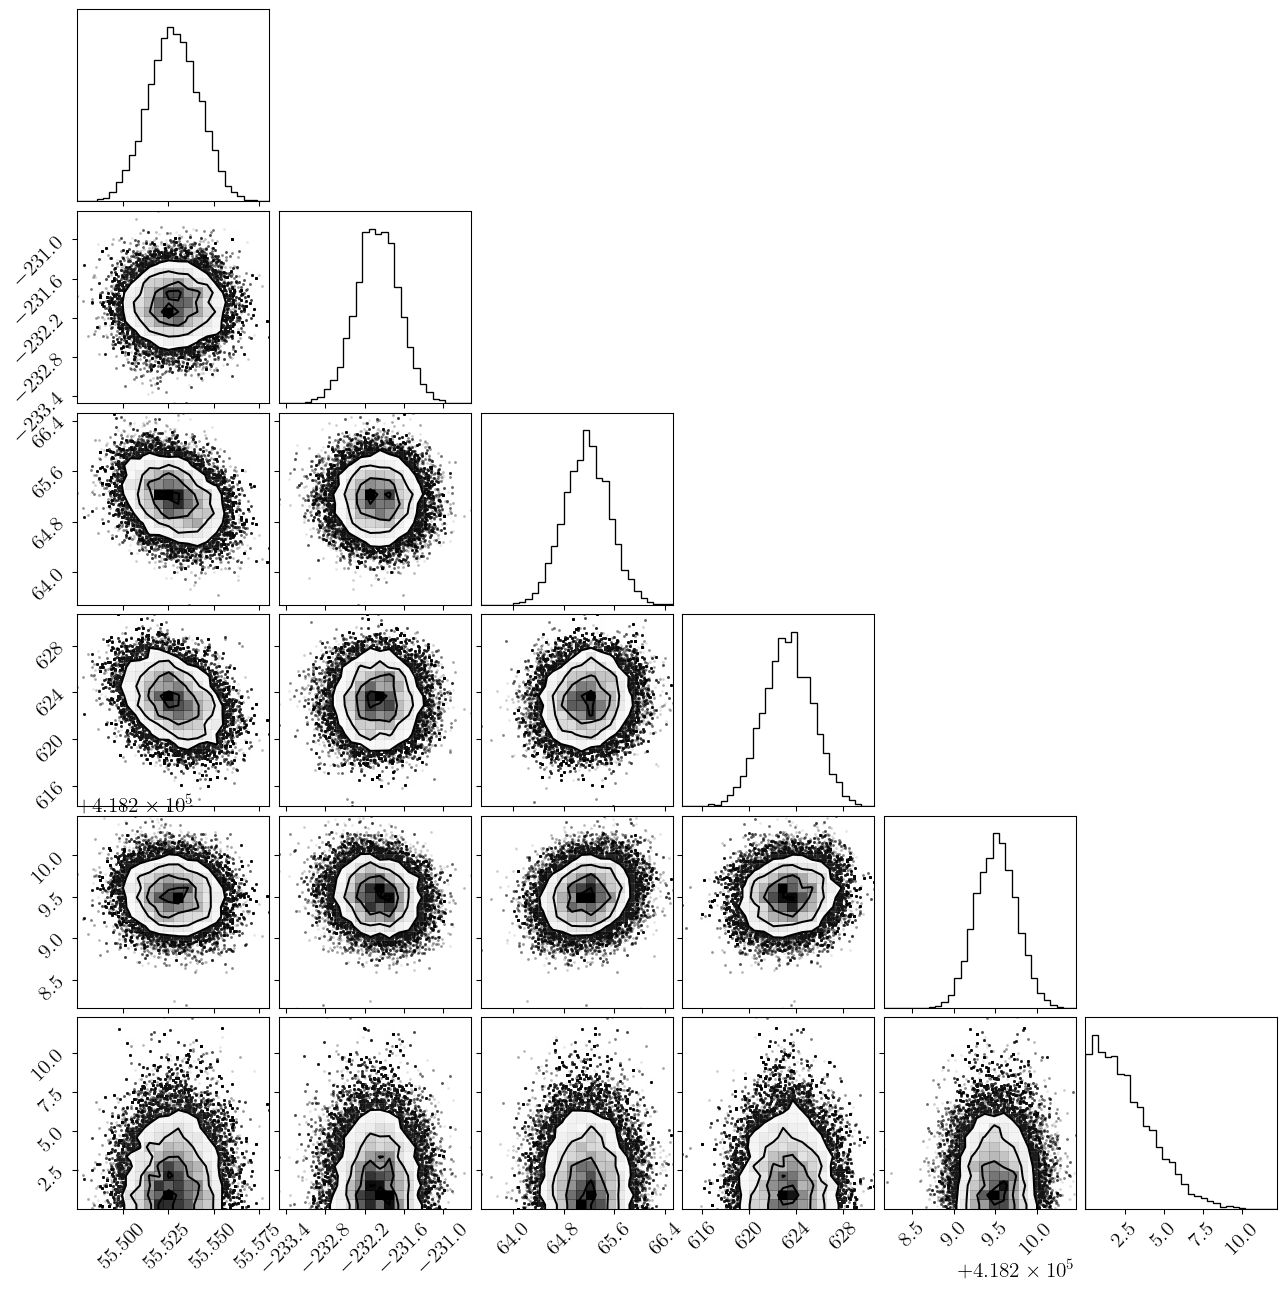

In [41]:
import corner

corner.corner(theta_5D.reshape(-1, 6), hist_bin_factor=1.5)

plt.show()

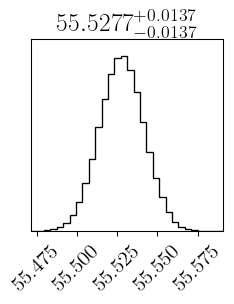

In [44]:
corner.corner(theta_1D.reshape(-1, 1), hist_bin_factor=1.5, show_titles=True, title_fmt=".4f",)

plt.show()

In [44]:
model_t = np.array(df_clean["ptime"])
model_y = np.array(df_clean["flux"])
model_dy = np.array(df_clean["err_flux"])

@nogiljit
def est_transit_depth_1D(omegas):
    depth = np.full_like(omegas, np.nan)
    for i, omega in enumerate(omegas):
        Xw = np.transpose(np.vstack((
            np.sin(omega * model_t),
            np.cos(omega * model_t),
            model_t,
            np.ones_like(model_t)
        )) / model_dy)

        A, B, C, D = np.linalg.solve(Xw.T @ Xw, Xw.T @ yw)

        transit_bg = A * np.sin(omega * transit_t) + B * np.cos(omega * transit_t) + C * transit_t + D
        depth[i] = np.mean(1 - (transit_y / transit_bg))
    return depth

omegas_all = theta_1D.ravel()
draw = np.random.choice(len(omegas_all), size=len(omegas_all)//5, replace=False)
depths = est_transit_depth_1D(omegas_all[draw])
plt.hist(depths, bins=50)

NameError: name 'theta_1D' is not defined

(array([5.0000e+00, 0.0000e+00, 0.0000e+00, 1.1000e+01, 1.3000e+01,
        6.8000e+01, 5.6000e+01, 1.3800e+02, 3.1900e+02, 5.0400e+02,
        8.9900e+02, 1.2790e+03, 1.7110e+03, 2.5370e+03, 3.1720e+03,
        5.2840e+03, 6.8610e+03, 8.3670e+03, 1.0508e+04, 9.9960e+03,
        1.2078e+04, 1.6183e+04, 1.6161e+04, 1.4901e+04, 1.5680e+04,
        1.4077e+04, 1.4100e+04, 1.1896e+04, 1.1195e+04, 1.0750e+04,
        8.2400e+03, 7.0050e+03, 5.2910e+03, 3.9940e+03, 2.9200e+03,
        2.0050e+03, 1.3250e+03, 8.5800e+02, 7.8900e+02, 4.4600e+02,
        2.6300e+02, 1.2300e+02, 4.0000e+01, 4.8000e+01, 2.1000e+01,
        1.4000e+01, 1.1000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.0001178 , 0.00011792, 0.00011803, 0.00011815, 0.00011827,
        0.00011839, 0.00011851, 0.00011862, 0.00011874, 0.00011886,
        0.00011898, 0.00011909, 0.00011921, 0.00011933, 0.00011945,
        0.00011957, 0.00011968, 0.0001198 , 0.00011992, 0.00012004,
        0.00012015, 0.00012027, 0.00012039, 0.

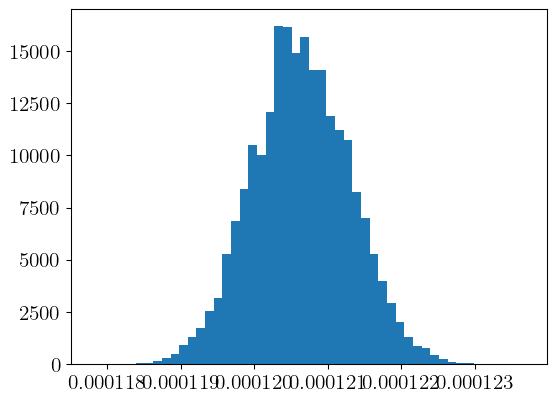

In [45]:
transit_t = np.array(df_transit_clean["ptime"])
transit_y = np.array(df_transit_clean["flux"])

@nogiljit
def est_transit_depth_5D(thetas):
    depth = np.full((thetas.shape[0],), np.nan)
    for i, (omega, A, B, C, D) in enumerate(thetas):
        transit_bg = A * np.sin(omega * transit_t) + B * np.cos(omega * transit_t) + C * transit_t + D
        depth[i] = np.mean(1 - (transit_y / transit_bg))
    return depth

omegas_all = theta_5D[:, 10000:, :5].reshape(-1, 5)
depths = est_transit_depth_5D(omegas_all)
plt.hist(depths, bins=50)

In [55]:
omegas_all[draw].shape

(52428, 5)